In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.ensemble._iforest import _average_path_length
import shap
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', None)

# Loading combined fbref/ transfermarkt data

In [2]:
df = pd.read_parquet(os.path.join('data', 'fbref_tm_combined.parquet'))

In [3]:
# Drop some negative columns that you might not want to identify players based on, e.g. number of yellow cards.
# penalties are rare so they tend to show up a lot in the outliers so removed for showing more interesting things
to_drop = ['performance_off', 'performance_crdy', 'performance_2crdy', 'performance_crdr', 'performance_fls',
           'performance_og', 'performance_pkcon', 'performance_pkwon', 'standard_fk', 'pass_types_fk', 'vs_dribbles_att',
           'outcomes_off', 'outcomes_out', 'outcomes_int', 'outcomes_blocks', 'standard_pk', 'playing_time_mn/mp', 'short_att',
           'pass_types_press', 'body_parts_right', 'body_parts_other', 'body_parts_head', 'a-xa', 'expected_np:g-xg',
           'aerial_duels_lost', 'miscon', 'dispos', 'err', 'standard_pkatt',]
df.drop(to_drop, axis='columns', inplace=True)
# drop gca_types_gca_og_for as usually very low (mostly 0, but ocassionally 1 or 2)
df.drop('gca_types_og', axis='columns', inplace=True)

# Drop centre backs / goalkeepers

Centre-back stats are notoriously hard and goalkeepers are judged differently so we drop them here.

In [4]:
mask_remove = ((df.position_tm == 'Centre-Back') | (df.pos == 'GK')) & (df.pos.isin(['GK', 'DF']))
df = df[~mask_remove].copy()

# Drop players with fewer than 700 minutes played over last two years

This is an arbitrary cut-off point (around 7.8 games)

In [5]:
df = df[df.playing_time_min >= 700].copy()
df.reset_index(drop=True, inplace=True)

# Add a code for the transfermarkt position

Note there is some disagreement between fbref and transfermarkt positions but it is broadly the same

In [6]:
df.loc[df.position_tm.str.contains('Midfield'), 'position_code'] = 0
df.loc[df.position_tm.str.contains('Back'), 'position_code'] = 1
df.loc[df.position_tm.str.contains('Striker'), 'position_code'] = 2
df.loc[df.position_tm.str.contains('Winger'), 'position_code'] = 2
df.loc[df.position_tm.str.contains('Forward'), 'position_code'] = 2

# Check for highly correlated columns and drop them

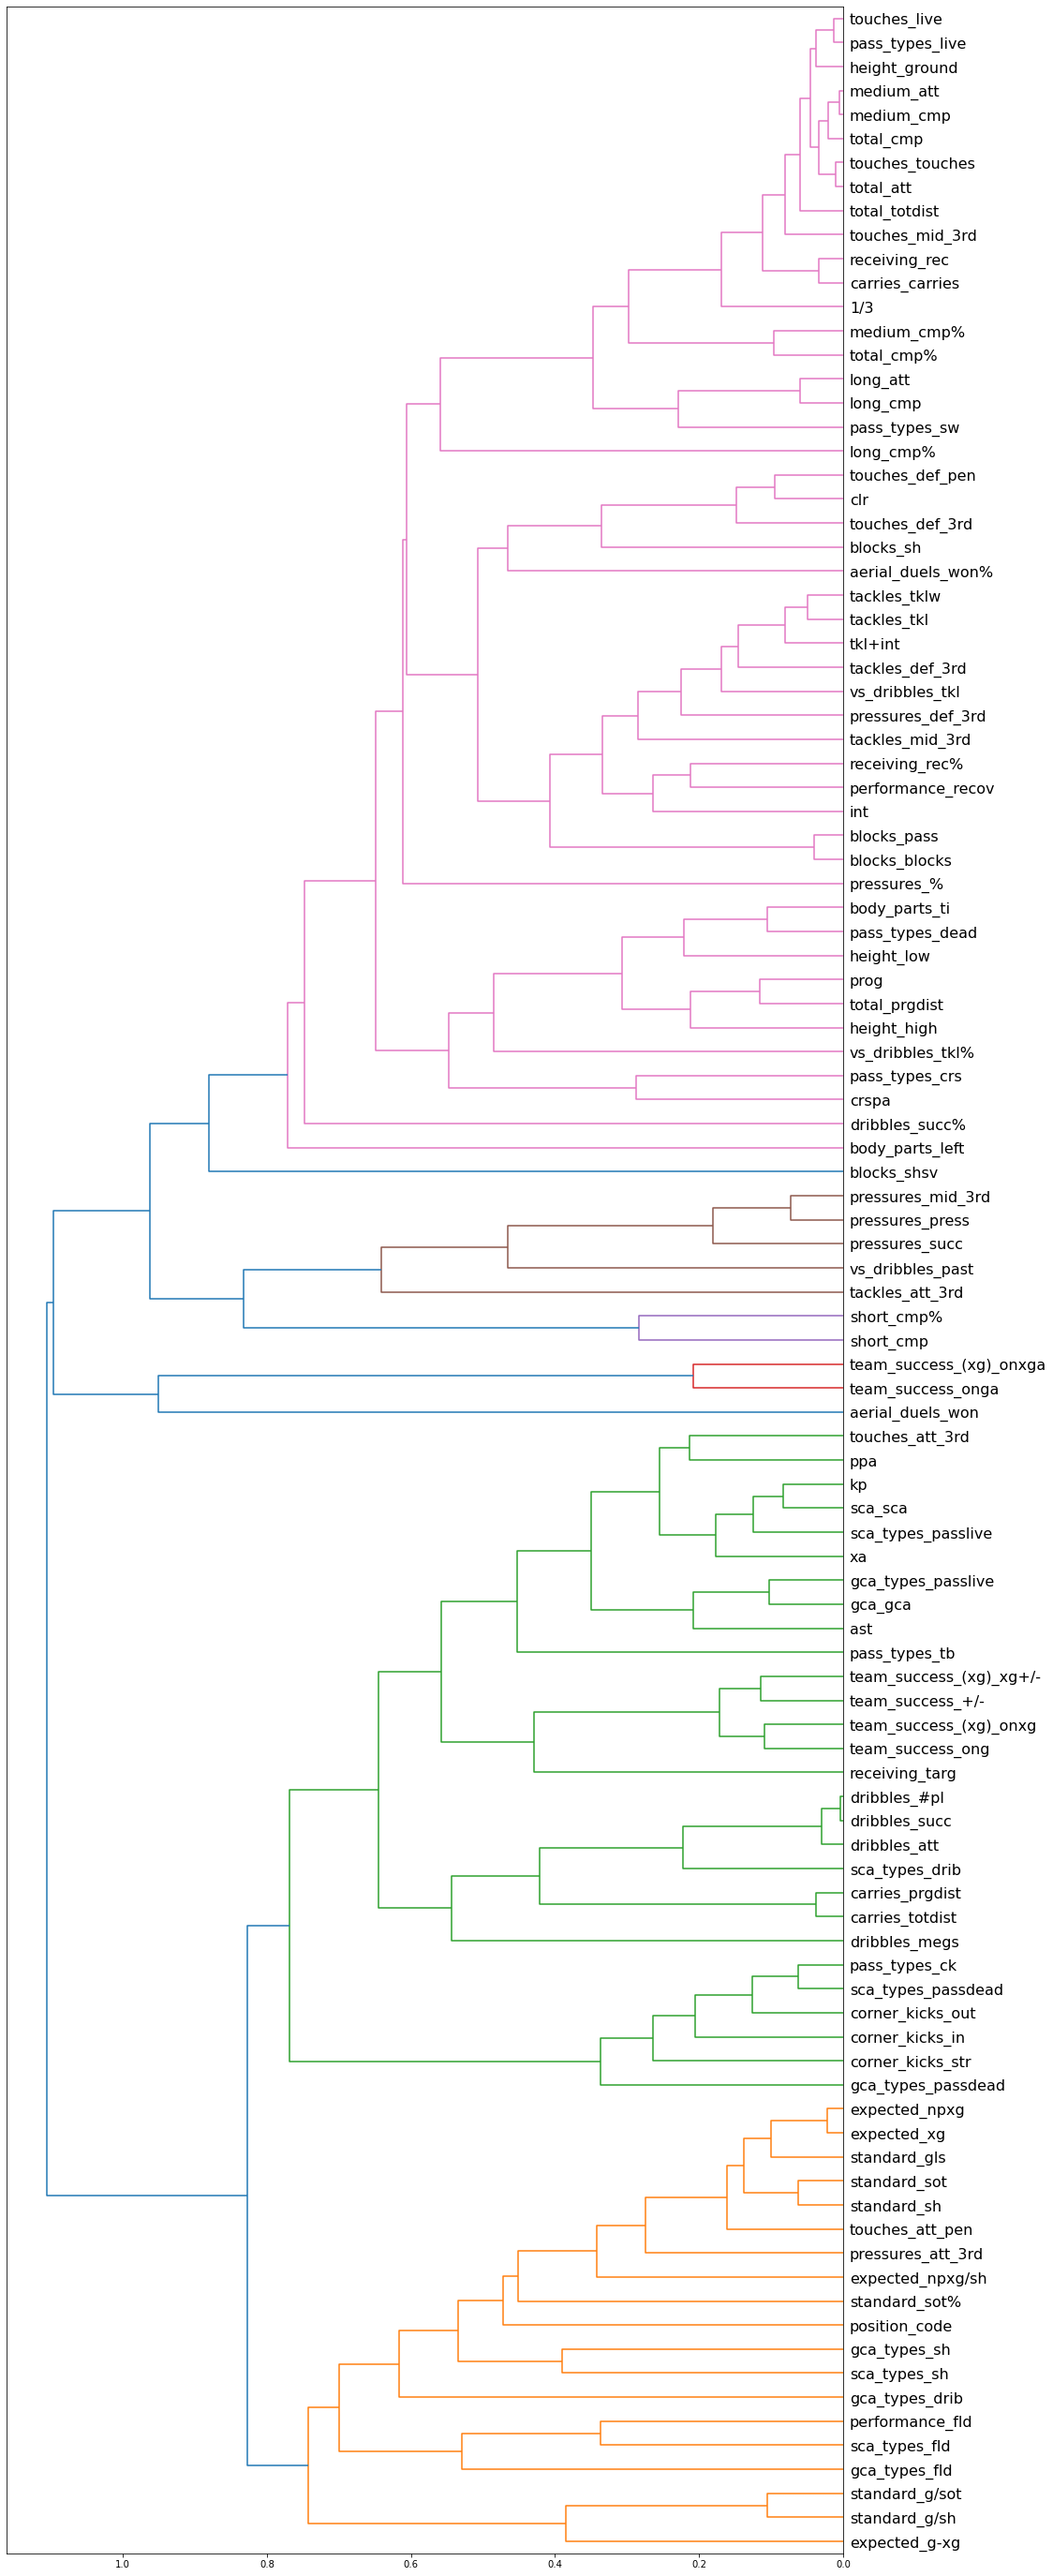

In [7]:
# https://stackoverflow.com/questions/34175462/dendrogram-using-pandas-and-scipy
corr_condensed = squareform(1 - df[df.columns[29:]].corr())
z = linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 50))
labels = list(df[df.columns[29:]].columns)
dend = dendrogram(z, orientation='left', labels=labels, leaf_font_size=16)

In [8]:
corr_cols = ['pass_types_live', 'medium_att', 'total_att', 'receiving_rec', 'long_att', 'medium_cmp%', 'pass_types_crs',
             'touches_def_pen',  'tackles_tkl', 'vs_dribbles_past','blocks_pass',  'body_parts_ti',  'tackles_mid_3rd', 
             'prog', 'expected_xg','standard_sh',  'standard_g/sot',  'expected_g-xg', 'kp', 'sca_types_passlive',
             'team_success_+/-','gca_types_passlive', 'team_success_ong', 'dribbles_#pl', 'carries_totdist', 'medium_cmp',
             'total_cmp','tkl+int', 'team_success_(xg)_onxg', 'standard_sot', 'height_ground', 'touches_mid_3rd',
             'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_str', 'touches_def_3rd', 'team_success_onga', 'dribbles_succ',
             'gca_gca','gca_types_passdead', 'sca_sca', 'standard_gls', 'ast', 'pass_types_dead', 'receiving_rec%',
             'gca_types_drib', 'gca_types_sh', 'gca_types_fld', 'short_cmp%', 'total_totdist', 'total_cmp%', 'height_low',
             'long_cmp', 'touches_live', 'dribbles_att', 'pass_types_ck', 'pressures_press', 'touches_touches']
df.drop(corr_cols, axis='columns', inplace=True)

In [9]:
print('Columns left:', len(df.columns[29:]))
list(df.columns[29:])

Columns left: 48


['team_success_(xg)_onxga',
 'team_success_(xg)_xg+/-',
 'tackles_tklw',
 'tackles_def_3rd',
 'tackles_att_3rd',
 'vs_dribbles_tkl',
 'pressures_succ',
 'pressures_def_3rd',
 'pressures_mid_3rd',
 'pressures_att_3rd',
 'blocks_blocks',
 'blocks_sh',
 'blocks_shsv',
 'int',
 'clr',
 'sca_types_passdead',
 'sca_types_drib',
 'sca_types_sh',
 'sca_types_fld',
 'performance_fld',
 'performance_recov',
 'aerial_duels_won',
 'total_prgdist',
 'short_cmp',
 'xa',
 '1/3',
 'ppa',
 'crspa',
 'pass_types_tb',
 'pass_types_sw',
 'height_high',
 'body_parts_left',
 'touches_att_3rd',
 'touches_att_pen',
 'dribbles_megs',
 'carries_carries',
 'carries_prgdist',
 'receiving_targ',
 'expected_npxg',
 'vs_dribbles_tkl%',
 'pressures_%',
 'aerial_duels_won%',
 'long_cmp%',
 'dribbles_succ%',
 'standard_g/sh',
 'expected_npxg/sh',
 'standard_sot%',
 'position_code']

# Change some values as we don't want to flag people as outliers for their poor stats (truncate stats for bottom quantile if more is better or top quantile if fewer is better)

In [10]:
X = df[df.columns[29:]].fillna(0)
# for goals allowed stats if in the top 50% change the value
cols_fewer_better = [X.columns[0]]
mask1 = X[cols_fewer_better] > X[cols_fewer_better].quantile(0.5)
# for other stats is in the bottom quantile change value
cols_more_better = X.columns[1:]
mask2 = X[cols_more_better] < X[cols_more_better].quantile(0.25)
mask = pd.concat([mask1, mask2], axis='columns')
quantile_values = pd.concat([X[cols_fewer_better].quantile(0.5), X[cols_more_better].quantile(0.25)])
X.mask(mask, quantile_values, axis='columns', inplace=True)

# Find outliers using isolation forest

In [11]:
clf = IsolationForest(random_state=42, contamination=0.1)
y_pred = clf.fit(X)
df['forest_score'] = clf.score_samples(X)

# Calculate shap values (to explain the outliers)

In [12]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
df_shap = pd.DataFrame(shap_values, columns=X.columns)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


# Get the five column names contributing to the the smallest (most negative) difference and their values

In [13]:
df['stat1_name'] = df_shap.T.idxmin()
df['stat1'] = df.lookup(df.index, df['stat1_name'])
df['stat2_name'] = df_shap.T.apply(lambda x: x.nsmallest(2).idxmax())
df['stat2'] = df.lookup(df.index, df['stat2_name'])
df['stat3_name'] = df_shap.T.apply(lambda x: x.nsmallest(3).idxmax())
df['stat3'] = df.lookup(df.index, df['stat3_name'])
df['stat4_name'] = df_shap.T.apply(lambda x: x.nsmallest(4).idxmax())
df['stat4'] = df.lookup(df.index, df['stat4_name'])
df['stat5_name'] = df_shap.T.apply(lambda x: x.nsmallest(5).idxmax())
df['stat5'] = df.lookup(df.index, df['stat5_name'])

# Sort by the score

In [14]:
df.sort_values('forest_score', inplace=True)
df.reset_index(drop=True, inplace=True)

# Subset columns

In [15]:
cols = ['player_tm', 'player', 'squad_tm', 'age_at_2020_09_01_tm', 'market_value_euro_millions_tm','league_tm',
        'year_tm', 'dob_tm', 'position_tm', 'pos', 'height_tm', 'foot_tm', 
        'joined_tm', 'contract_expires_tm', 
        'player_link_tm', 'player_link_fbref', '90s', 'playing_time_mp', 'playing_time_min',
        'forest_score', 'stat1_name', 'stat1', 'stat2_name', 'stat2', 'stat3_name', 'stat3',
        'stat4_name', 'stat4', 'stat5_name', 'stat5']
df_subset = df[cols].copy()

In [16]:
df_subset.rename({'player_tm': 'player_name_transfermarkt',
                  'player': 'player_name_fbref',
                  'dob_tm': 'dob_transfermarkt',
                  'age_at_2020_09_01_tm': 'age_years_at_2020_09_01',
                  'position_tm': 'position_transfermarkt',
                  'pos': 'position_fbref',
                  'height_tm': 'height_transfermarkt',
                  'foot_tm': 'foot_transfermarkt',
                  'squad_tm': 'squad_transfermarkt', 
                  'league_tm': 'league_transfermarkt',
                  'joined_tm': 'joined_transfermarkt',
                  'contract_expires_tm': 'contract_expires_transfermarkt',
                  'market_value_euro_millions_tm': 'market_value_euros_millions', 
                  'year_tm': 'year_of_valuation',
                  'player_link_tm': 'player_link_transfermarkt',
                  'player_link_fbref': 'player_link_fbref'}, axis='columns', inplace=True)

# Show top 30 outliers

In [17]:
df_subset.head(30)

,player_name_transfermarkt,player_name_fbref,squad_transfermarkt,age_years_at_2020_09_01,market_value_euros_millions,league_transfermarkt,year_of_valuation,dob_transfermarkt,position_transfermarkt,position_fbref,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,player_link_transfermarkt,player_link_fbref,90s,playing_time_mp,playing_time_min,forest_score,stat1_name,stat1,stat2_name,stat2,stat3_name,stat3,stat4_name,stat4,stat5_name,stat5
0,Neymar,Neymar,Paris S-G,28.6,128.0,Ligue 1,2020,1992-02-05,Left Winger,"MF,FW",1.75,right,2017-08-03,2022-06-30,/neymar/profil/spieler/68290,/en/players/69384e5d/Neymar,30.6,32.0,2757.0,-0.649708,performance_fld,3.917,pass_types_tb,1.240,sca_types_fld,0.653,xa,0.366,ppa,4.505
1,Lionel Messi,Lionel Messi,Barcelona,33.2,112.0,LaLiga,2020,1987-06-24,Right Winger,"FW,MF",1.70,left,2005-07-01,2021-06-30,/lionel-messi/profil/spieler/28003,/en/players/d70ce98e/Lionel-Messi,62.1,67.0,5593.0,-0.630303,sca_types_drib,1.159,pass_types_tb,1.416,sca_types_fld,0.885,xa,0.463,ppa,4.296
2,Thiago,Thiago Alcántara,Bayern Munich,29.4,48.0,Bundesliga,2020,1991-04-11,Central Midfield,MF,1.74,right,2013-07-14,2021-06-30,/thiago/profil/spieler/60444,/en/players/77e84962/Thiago-Alcantara,46.5,54.0,4179.0,-0.591848,1/3,9.928,pass_types_sw,4.996,receiving_targ,80.696,performance_recov,14.817,long_cmp%,84.900
3,Marco Verratti,Marco Verratti,Paris S-G,27.8,60.0,Ligue 1,2020,1992-11-05,Central Midfield,MF,1.65,right,2012-07-18,2024-06-30,/marco-verratti/profil/spieler/102558,/en/players/1467af0d/Marco-Verratti,37.4,46.0,3361.0,-0.589052,1/3,10.738,pass_types_tb,0.937,receiving_targ,95.891,tackles_att_3rd,0.669,short_cmp,1.821
4,James Rodríguez,James Rodríguez,Everton,29.1,32.0,Premier League,2020,1991-07-12,Attacking Midfield,MF,1.81,left,2020-09-07,2022-06-30,/james-rodriguez/profil/spieler/88103,/en/players/715bf047/James-Rodriguez,17.3,28.0,1557.0,-0.583675,team_success_(xg)_onxga,0.607,sca_types_passdead,1.387,pass_types_tb,0.578,body_parts_left,65.607,pass_types_sw,4.798
5,Alphonso Davies,Alphonso Davies,Bayern Munich,19.8,60.0,Bundesliga,2020,2000-11-02,Left-Back,DF,1.81,left,2019-01-01,2025-06-30,/alphonso-davies/profil/spieler/424204,/en/players/d781d855/Alphonso-Davies,25.7,35.0,2314.0,-0.583510,dribbles_megs,0.545,standard_g/sh,0.290,pressures_%,42.500,expected_npxg/sh,0.160,tackles_tklw,1.945
6,Kevin De Bruyne,Kevin De Bruyne,Manchester City,29.2,120.0,Premier League,2020,1991-06-28,Attacking Midfield,MF,1.81,right,2015-08-30,2023-06-30,/kevin-de-bruyne/profil/spieler/88755,/en/players/e46012d4/Kevin-De-Bruyne,41.8,54.0,3766.0,-0.578771,pass_types_tb,1.004,xa,0.523,ppa,4.015,sca_types_passdead,1.171,team_success_(xg)_xg+/-,1.766
7,Emiliano Buendía,Emi Buendía,Norwich City,23.7,14.5,Championship,2020,1996-12-25,Right Winger,"FW,MF",1.72,right,2018-07-01,2024-06-30,/emiliano-buendia/profil/spieler/321247,/en/players/66b76d44/Emi-Buendia,27.4,36.0,2464.0,-0.574934,sca_types_passdead,1.096,pass_types_tb,0.584,tackles_def_3rd,2.265,pressures_def_3rd,11.250,tackles_tklw,2.119
8,Adam Lallana,Adam Lallana,Brighton,32.3,9.5,Premier League,2020,1988-05-10,Attacking Midfield,"MF,FW",1.72,both,2020-07-27,2023-06-30,/adam-lallana/profil/spieler/43530,/en/players/99813635/Adam-Lallana,9.4,28.0,850.0,-0.571772,tackles_tklw,2.435,pressures_succ,9.953,team_success_(xg)_onxga,0.699,blocks_blocks,3.071,short_cmp,1.588
9,Marçal,Fernando Marçal,Lyon,31.5,2.4,Ligue 1,2019,1989-02-19,Left-Back,DF,1.78,left,2017-07-01,2021-06-30,/marcal/profil/spieler/137745,/en/players/9ae9eaea/Fernando-Marcal,19.0,23.0,1707.0,-0.564554,body_parts_left,65.325,pressures_%,42.200,vs_dribbles_tkl%,60.000,aerial_duels_won%,69.700,1/3,6.960


# Show top 30 outliers aged 26 or under and valued at 15 mill or under

In [18]:
df_subset[(df_subset.age_years_at_2020_09_01 <= 26) & (df_subset.market_value_euros_millions <= 15)].head(30)

,player_name_transfermarkt,player_name_fbref,squad_transfermarkt,age_years_at_2020_09_01,market_value_euros_millions,league_transfermarkt,year_of_valuation,dob_transfermarkt,position_transfermarkt,position_fbref,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,player_link_transfermarkt,player_link_fbref,90s,playing_time_mp,playing_time_min,forest_score,stat1_name,stat1,stat2_name,stat2,stat3_name,stat3,stat4_name,stat4,stat5_name,stat5
7,Emiliano Buendía,Emi Buendía,Norwich City,23.7,14.5,Championship,2020,1996-12-25,Right Winger,"FW,MF",1.72,right,2018-07-01,2024-06-30,/emiliano-buendia/profil/spieler/321247,/en/players/66b76d44/Emi-Buendia,27.4,36.0,2464.0,-0.574934,sca_types_passdead,1.096,pass_types_tb,0.584,tackles_def_3rd,2.265,pressures_def_3rd,11.250,tackles_tklw,2.119
24,Yusuf Yazici,Yusuf Yazıcı,Lille,23.6,13.0,Ligue 1,2020,1997-01-29,Attacking Midfield,"MF,FW",1.83,left,2019-08-06,2024-06-30,/yusuf-yazici/profil/spieler/386726,/en/players/f5c8b425/Yusuf-Yazici,9.4,18.0,848.0,-0.541902,sca_types_passdead,2.123,dribbles_megs,0.425,tackles_att_3rd,0.637,xa,0.287,pass_types_sw,3.927
40,Moussa Djenepo,Moussa Djenepo,Southampton,22.2,11.0,Premier League,2020,1998-06-15,Left Winger,"MF,DF",1.77,right,2019-07-01,2023-06-30,/moussa-djenepo/profil/spieler/485424,/en/players/254147d4/Moussa-Djenepo,10.3,18.0,928.0,-0.525243,sca_types_drib,1.067,performance_fld,2.909,sca_types_fld,0.776,tackles_def_3rd,1.746,blocks_blocks,2.328
51,Jean-Kévin Augustin,Jean-Kévin Augustin,RB Leipzig,23.2,9.5,Bundesliga,2020,1997-06-16,Centre-Forward,FW,1.77,right,2017-07-06,2022-06-30,/jean-kevin-augustin/profil/spieler/264956,/en/players/97bfa797/Jean-Kevin-Augustin,8.1,27.0,727.0,-0.519489,dribbles_megs,0.495,sca_types_fld,0.990,performance_fld,2.971,long_cmp%,83.300,pressures_%,36.500
66,Ademola Lookman,Ademola Lookman,RB Leipzig,22.9,13.5,Bundesliga,2020,1997-10-20,Left Winger,"MF,FW",1.74,right,2019-07-25,2024-06-30,/ademola-lookman/profil/spieler/406040,/en/players/7c104bb7/Ademola-Lookman,10.3,32.0,927.0,-0.513510,vs_dribbles_tkl%,78.600,sca_types_drib,0.680,sca_types_sh,0.388,performance_fld,2.524,dribbles_megs,0.291
73,Mert Müldür,Mert Müldür,Sassuolo,21.4,10.0,Serie A,2020,1999-04-03,Right-Back,DF,1.84,both,2019-08-20,2024-06-30,/mert-muldur/profil/spieler/353922,/en/players/1295552e/Mert-Muldur,14.1,24.0,1273.0,-0.512202,tackles_def_3rd,2.333,standard_sot%,53.800,vs_dribbles_tkl%,59.500,tackles_tklw,2.121,sca_types_drib,0.566
76,Óliver Torres,Óliver Torres,Sevilla,25.8,13.5,LaLiga,2020,1994-11-10,Central Midfield,"MF,FW",1.75,right,2019-07-15,2024-06-30,/oliver-torres/profil/spieler/214775,/en/players/58a9a4d9/Oliver-Torres,17.7,28.0,1596.0,-0.511164,team_success_(xg)_onxga,0.812,pass_types_sw,4.004,vs_dribbles_tkl,1.917,standard_sot%,62.500,vs_dribbles_tkl%,51.500
82,Marcelo Saracchi,Marcelo Saracchi,RB Leipzig,22.4,9.0,Bundesliga,2019,1998-04-23,Left-Back,DF,1.72,left,2018-07-01,2023-06-30,/marcelo-saracchi/profil/spieler/373916,/en/players/1c96ad85/Marcelo-Saracchi,9.3,13.0,832.0,-0.509344,vs_dribbles_tkl%,60.000,aerial_duels_won%,70.600,performance_recov,13.738,height_high,19.147,ppa,2.055
88,Bernardo,Bernardo,Brighton,25.3,4.8,Premier League,2020,1995-05-14,Left-Back,DF,1.86,left,2018-07-05,2022-06-30,/bernardo/profil/spieler/364258,/en/players/17370b95/Bernardo,27.0,36.0,2431.0,-0.507254,tackles_def_3rd,2.221,blocks_sh,0.703,blocks_shsv,0.037,tackles_tklw,2.036,vs_dribbles_tkl%,57.600
94,Yassine Benrahou,Yassine Benrahou,Nîmes,21.6,4.0,Ligue 1,2020,1999-01-24,Attacking Midfield,"MF,FW",1.70,right,2020-07-01,2023-06-30,/yassine-benrahou/profil/spieler/344599,/en/players/fbf76716/Yassine-Benrahou,12.4,19.0,1107.0,-0.505929,sca_types_passdead,1.220,performance_fld,2.764,sca_types_sh,0.407,xa,0.260,sca_types_fld,0.407


# Show older outliers with a low valuation

In [19]:
df_subset[(df_subset.market_value_euros_millions < 5) & (df_subset.age_years_at_2020_09_01 > 26) & 
          (df_subset.age_years_at_2020_09_01 < 30)].head(15)

,player_name_transfermarkt,player_name_fbref,squad_transfermarkt,age_years_at_2020_09_01,market_value_euros_millions,league_transfermarkt,year_of_valuation,dob_transfermarkt,position_transfermarkt,position_fbref,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,player_link_transfermarkt,player_link_fbref,90s,playing_time_mp,playing_time_min,forest_score,stat1_name,stat1,stat2_name,stat2,stat3_name,stat3,stat4_name,stat4,stat5_name,stat5
61,Abdoul Kader Bamba,Abdoul Kader Bamba,Nantes,26.3,1.6,Ligue 1,2020,1994-05-25,Right Winger,"FW,MF",1.76,right,2019-07-01,2024-06-30,/abdoul-kader-bamba/profil/spieler/560725,/en/players/32f3d97e/Abdoul-Kader-Bamba,16.3,27.0,1468.0,-0.514800,blocks_shsv,0.061,performance_fld,2.943,sca_types_fld,0.674,xa,0.288,carries_prgdist,221.628
72,Sebastián Cristóforo,Sebastián Cristóforo,Fiorentina,27.0,1.4,Serie A,2020,1993-08-23,Central Midfield,MF,1.73,right,2017-07-01,2021-06-30,/sebastian-cristoforo/profil/spieler/188157,/en/players/3c05c659/Sebastian-Cristoforo,15.7,34.0,1417.0,-0.512218,tackles_att_3rd,0.889,tackles_tklw,2.477,blocks_blocks,3.112,performance_fld,2.731,pressures_succ,8.066
85,Jamilu Collins,Jamilu Collins,Paderborn 07,26.1,2.4,2. Bundesliga,2020,1994-08-05,Left-Back,DF,1.83,left,2017-09-06,2021-06-30,/jamilu-collins/profil/spieler/254934,/en/players/33a95e0a/Jamilu-Collins,29.6,30.0,2668.0,-0.508263,blocks_shsv,0.101,blocks_blocks,3.373,blocks_sh,0.675,int,2.463,vs_dribbles_tkl%,53.100
96,Kevin Stöger,Kevin Stöger,Düsseldorf,27.0,4.0,2. Bundesliga,2019,1993-08-27,Attacking Midfield,MF,1.75,left,2018-07-01,2020-06-30,/kevin-stoger/profil/spieler/106872,/en/players/e5649a78/Kevin-Stoger,37.6,42.0,3386.0,-0.505186,pass_types_tb,0.399,pass_types_sw,3.828,1/3,5.927,performance_fld,2.233,sca_types_passdead,0.797
140,Sam Byram,Sam Byram,Norwich City,27.0,2.8,Championship,2020,1993-09-16,Right-Back,DF,1.83,right,2019-07-16,2023-06-30,/sam-byram/profil/spieler/236953,/en/players/1bf811d4/Sam-Byram,14.4,17.0,1293.0,-0.496106,blocks_blocks,3.480,tackles_def_3rd,1.949,blocks_sh,0.696,clr,5.220,vs_dribbles_tkl,1.671
141,Onel Hernández,Onel Hernández,Norwich City,27.6,3.2,Championship,2020,1993-02-01,Left Winger,"FW,MF",1.72,right,2018-01-25,2023-06-30,/onel-hernandez/profil/spieler/109751,/en/players/007b39a5/Onel-Hernandez,15.4,26.0,1384.0,-0.495967,blocks_shsv,0.065,tackles_att_3rd,0.650,sca_types_drib,0.650,pressures_%,34.300,tackles_tklw,1.756
143,Tom Trybull,Tom Trybull,Norwich City,27.5,3.2,Championship,2020,1993-03-09,Defensive Midfield,MF,1.81,right,2017-08-04,2022-06-30,/tom-trybull/profil/spieler/93831,/en/players/552aa16c/Tom-Trybull,12.6,16.0,1130.0,-0.495673,tackles_def_3rd,2.071,pressures_succ,9.000,pressures_def_3rd,13.938,tackles_tklw,2.389,long_cmp%,84.300
150,Sanjin Prcic,Sanjin Prcić,Strasbourg,26.8,1.6,Ligue 1,2020,1993-11-20,Central Midfield,MF,1.82,right,2019-09-02,2022-06-30,/sanjin-prcic/profil/spieler/125783,/en/players/51c30111/Sanjin-Prcic,18.5,26.0,1663.0,-0.494482,aerial_duels_won%,77.400,pass_types_sw,4.762,blocks_sh,0.812,1/3,5.628,sca_types_passdead,0.812
156,Danilo Cataldi,Danilo Cataldi,Lazio,26.1,3.2,Serie A,2020,1994-08-06,Central Midfield,MF,1.80,right,2013-07-01,2024-06-30,/danilo-cataldi/profil/spieler/199733,/en/players/ba3d3bea/Danilo-Cataldi,13.0,33.0,1170.0,-0.493149,sca_types_passdead,1.462,1/3,5.923,carries_carries,49.154,total_prgdist,357.077,standard_g/sh,0.130
166,Riccardo Saponara,Riccardo Saponara,Fiorentina,28.7,2.5,Serie A,2020,1991-12-21,Attacking Midfield,"MF,FW",1.84,right,2018-07-01,2022-06-30,/riccardo-saponara/profil/spieler/88909,/en/players/3bb7af3b/Riccardo-Saponara,22.5,39.0,2020.0,-0.491701,ppa,2.495,pass_types_tb,0.401,aerial_duels_won%,61.900,dribbles_megs,0.267,short_cmp,1.248


# Save to excel

In [20]:
df_subset.to_excel(os.path.join('data', 'outliers.xlsx'))